##### Phase Objective: This notebook focuses on applying the CLTV predictions from our previous analysis. We will segment customers into actionable groups and propose tailored business strategies for each segment, showcasing how my data science work can directly drive business value.


In [50]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [52]:
print("Loading necessary data...")
try:
    # Load the feature-engineered data (RFM, Tenure, etc.)
    df_features = pd.read_csv('../data/processed/customer_features_rfm.csv')
    # Load the CLTV predictions from the probabilistic model
    df_predictions = pd.read_csv('../data/processed/cltv_predictions_probabilistic.csv')

    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure previous notebooks were run and saved.")
    exit()

Loading necessary data...
Data loaded successfully.


In [53]:
df_features.head()

,CustomerID,Recency,Frequency,Monetary,Tenure,Frequency_model,Recency_Model,AOV,AvgPurchaseGap,ProductDiversity
0,12346,326,1,5788770.00,326,0,0,5788770.00,0.00,1
1,12347,2,7,323250.00,367,6,365,46178.57,2.00,103
2,12348,75,4,134793.00,358,3,282,33698.25,9.40,22
3,12349,19,1,131816.25,19,0,0,131816.25,0.00,73
4,12350,310,1,25080.00,310,0,0,25080.00,0.00,17


In [54]:
df_predictions.head()

,CustomerID,frequency,recency,T,monetary,predicted_cltv
0,12346,0,0,326,5788770.00,1135860.92
1,12347,6,365,367,323250.00,14002793.15
2,12348,3,282,358,134793.00,3595754.25
3,12349,0,0,19,131816.25,5826012.14
4,12350,0,0,310,25080.00,1185003.05


In [55]:
# Merge the features and predictions into a single DataFrame for analysis
# We will use the CustomerID to join the two dataframes
customer_df = pd.merge(df_features, df_predictions[['CustomerID', 'predicted_cltv']], on='CustomerID', how='inner')

print(f"\nFinal combined DataFrame shape: {customer_df.shape}")


Final combined DataFrame shape: (4338, 11)


In [56]:
print("Sample of the combined DataFrame:")
print(customer_df.head())

Sample of the combined DataFrame:
   CustomerID  Recency  Frequency   Monetary  Tenure  Frequency_model  Recency_Model        AOV  AvgPurchaseGap  ProductDiversity  predicted_cltv
0       12346      326          1 5788770.00     326                0              0 5788770.00            0.00                 1      1135860.92
1       12347        2          7  323250.00     367                6            365   46178.57            2.00               103     14002793.15
2       12348       75          4  134793.00     358                3            282   33698.25            9.40                22      3595754.25
3       12349       19          1  131816.25      19                0              0  131816.25            0.00                73      5826012.14
4       12350      310          1   25080.00     310                0              0   25080.00            0.00                17      1185003.05


##### Customer segmentation based on predicted cltv

##### We will segment customers into tiers based on their predicted CLTV.
##### A common approach is using quantiles (e.g., top 20%, middle 60%, bottom 20%).
##### We will create 3 tiers: High-Value, Medium-Value, and Low-Value

In [57]:
# Remove any customers with 0 CLTV to focus on those with predicted future spend
customer_df = customer_df[customer_df['predicted_cltv'] > 0]


In [58]:
# Remove any customers with 0 CLTV to focus on those with predicted future spend
customer_df.head()


,CustomerID,Recency,Frequency,Monetary,Tenure,Frequency_model,Recency_Model,AOV,AvgPurchaseGap,ProductDiversity,predicted_cltv
0,12346,326,1,5788770.00,326,0,0,5788770.00,0.00,1,1135860.92
1,12347,2,7,323250.00,367,6,365,46178.57,2.00,103,14002793.15
2,12348,75,4,134793.00,358,3,282,33698.25,9.40,22,3595754.25
3,12349,19,1,131816.25,19,0,0,131816.25,0.00,73,5826012.14
4,12350,310,1,25080.00,310,0,0,25080.00,0.00,17,1185003.05


##### Calculate the quantiles for our tiers

In [59]:

quantiles = customer_df['predicted_cltv'].quantile([0.2, 0.5, 0.8]).to_dict()
print("\nCLTV Quantile Tiers:")
print(quantiles)


CLTV Quantile Tiers:
{0.2: 1439913.300647231, 0.5: 3250112.649247155, 0.8: 7370239.277544349}


##### Function to assign a segment based on predicted CLTV

In [60]:

def cltv_segment(cltv):
    if cltv >= quantiles[0.8]:
        return 'High-Value'
    elif cltv >= quantiles[0.5]:
        return 'Medium-Value'
    elif cltv >= quantiles[0.2]:
        return 'Low-Value'
    else:
        return 'At-Risk/Churn'

####  Apply the segmentation function to the DataFrame

In [61]:

customer_df['Segment'] = customer_df['predicted_cltv'].apply(cltv_segment)


In [62]:
print("\nCustomer counts per segment:")
print(customer_df['Segment'].value_counts())


Customer counts per segment:
Segment
Medium-Value     1304
Low-Value        1298
At-Risk/Churn     868
High-Value        868
Name: count, dtype: int64


####  Now, let's analyze the characteristics of each segment to understand what makes a customer valuable or not. We'll look at the mean of our key features.

In [63]:

segment_summary = customer_df.groupby('Segment').agg(
    # RFM metrics
    Avg_Recency=('Recency', 'mean'),
    Avg_Frequency=('Frequency', 'mean'),
    Avg_Monetary=('Monetary', 'mean'),
    Avg_Tenure=('Tenure', 'mean'),
    Avg_AOV=('AOV', 'mean'),
    Avg_PurchaseGap=('AvgPurchaseGap', 'mean'),
    Avg_ProductDiversity=('ProductDiversity', 'mean'),
    # Predictions
    Avg_Predicted_CLTV=('predicted_cltv', 'mean')
).reset_index()

In [64]:
# Sort by Avg_Predicted_CLTV to show the hierarchy
segment_summary.sort_values(by='Avg_Predicted_CLTV', ascending=False, inplace=True)

print("\nSummary of key customer characteristics by segment:")
print(segment_summary)



Summary of key customer characteristics by segment:
         Segment  Avg_Recency  Avg_Frequency  Avg_Monetary  Avg_Tenure  Avg_AOV  Avg_PurchaseGap  Avg_ProductDiversity  Avg_Predicted_CLTV
1     High-Value        20.90          12.03     549572.77      280.18 51349.86             2.18                145.30        112628554.62
3   Medium-Value        39.31           2.78      72523.85      139.81 28137.00             1.76                 53.22          4792781.18
2      Low-Value       104.28           2.22      49529.80      211.26 25226.24             3.65                 37.90          2181551.60
0  At-Risk/Churn       226.58           1.71      35311.89      309.89 25590.71             5.80                 25.43          1160765.70


#### Visualizations of findings

C:\Users\DELL\AppData\Local\Temp\ipykernel_8940\4116103442.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Segment', y='Avg_Predicted_CLTV', data=segment_summary, palette='viridis')


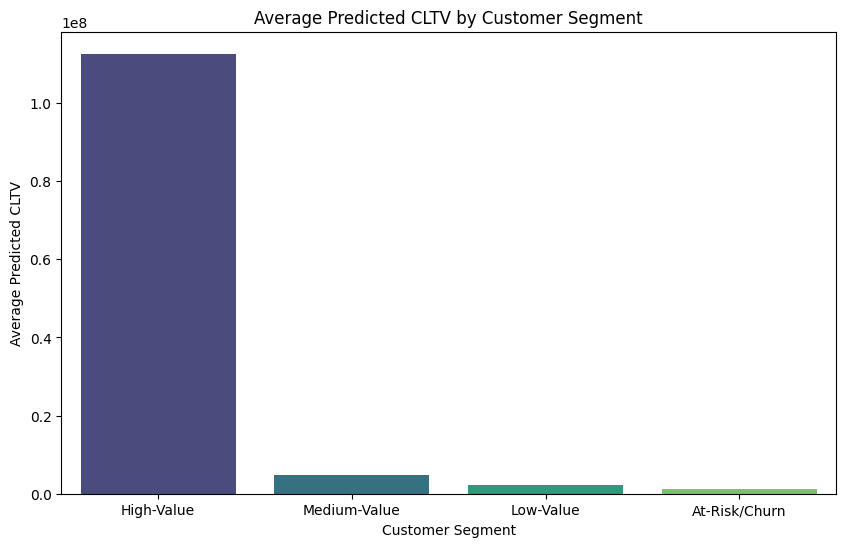

In [65]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Segment', y='Avg_Predicted_CLTV', data=segment_summary, palette='viridis')
plt.title('Average Predicted CLTV by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Predicted CLTV')
plt.show()

#### Key Insights

#### We divided our customers into four segments based on their purchase behavior and predicted future value (CLTV). These are my understanding:

#### 1. High-Value Customers
- Buy frequently (12+ times on average)
- Spend a lot (₹549,573 average total spend)
- Recently active (last purchase ~21 days ago)
- Very high predicted CLTV (₹11+ crores)

These are our **most valuable and loyal customers**.  
We should focus on **retaining them** with loyalty programs, early offers, and personalized services.

---

#### 2. Medium-Value Customers
- Buy occasionally (~3 times)
- Spend a moderate amount (₹72,524)
- Less recent activity (~39 days ago)
- Good predicted CLTV (~₹47.9 lakhs)

These are **potentially loyal customers**.  
We can **nurture them** with special deals, reminders, and upselling strategies.

---

#### 3. Low-Value Customers
- Few purchases (~2 times)
- Lower spend (₹49,530)
- Purchase gaps of around 3.6 days
- Low predicted CLTV (~₹21.8 lakhs)

These customers show **limited engagement**.  
Try **re-engagement campaigns**, product recommendations, or discounts to boost interest.

---

#### 4. At-Risk / Churn Customers
- Haven’t purchased in a long time (~227 days ago)
- Low purchase frequency (~1.7 times)
- Lowest spend (₹35,312)
- Lowest predicted CLTV (~₹11.6 lakhs)

These customers are **likely to churn** or have already left.  
Consider **win-back campaigns**, surveys, or exit offers to bring them back.

---

#### Conclusion:
This segmentation helps us understand which customers:
- Are most profitable (High-Value)
- Can be retained or upgraded (Medium & Low-Value)
- Need attention before we lose them (At-Risk)


### Strategy and A/B Testing Framework

##### Segment Summary – Strategic Insights

The `segment_summary` table provides the foundation for our business strategy.  
By analyzing the average RFM (Recency, Frequency, Monetary) and other features for each group, we can understand their behavior and needs.

---

##### High-Value Segment
These customers are our **"VIPs"**.

- **Highest predicted CLTV**
- **High average frequency**: 12.03 purchases
- **Lowest recency**: 20.90 days since last purchase
- **High monetary value**: ₹7327.64 average per transaction
- **High product diversity**: 145.30 products

These are our **most loyal and engaged customers**.  
We should focus on **retention, personalized offers, and loyalty programs**.

---

##### Medium-Value Segment
This group shows **moderate but promising engagement**.

- **Average frequency**: 2.78
- **Recency**: 39.31 days
- **Moderate CLTV potential**

With the right nudges, they could **move up to the High-Value group**.  
Use **targeted promotions, upselling, and product recommendations**.

---

##### Low-Value Segment
These customers have **lower engagement and predicted CLTV**.

- **Low frequency**: 2.22
- **High recency**: 104.28 days
- **Lower transaction value**

Many may be **one-time buyers**.  
Focus on **cost-effective re-engagement** like email campaigns or discounts.

---

##### At-Risk / Churn Segment
This segment has the **lowest predicted CLTV** and **least recent activity**.

- **Very high recency**: 226.58 days
- **Very low frequency**
- **Lowest spend behavior**

They are **likely to churn or already inactive**.  
Consider **win-back strategies**, exit surveys, or **accept churn** and reallocate resources.

---

##### Conclusion:
Use this segmentation to:

- **Retain and reward High-Value customers**
- **Grow Medium-Value customers**
- **Re-engage Low-Value customers**
- **Decide whether to win back or let go of Churned customers**


In [66]:
# Create a DataFrame for strategies
strategies_dict = {
    'Segment': ['High-Value', 'Medium-Value', 'Low-Value', 'At-Risk/Churn'],
    'Proposed Strategy': [
        'Tiered loyalty program, early access, exclusive offers.',
        'Targeted upselling and cross-selling campaigns.',
        'Cost-effective re-engagement emails with small discounts.',
        'Final, high-discount "win-back" offers.'
    ]
}
df_strategies = pd.DataFrame(strategies_dict)

In [67]:
df_strategies=pd.DataFrame(strategies_dict)

In [68]:
df_strategies

,Segment,Proposed Strategy
0,High-Value,"Tiered loyalty program, early access, exclusiv..."
1,Medium-Value,Targeted upselling and cross-selling campaigns.
2,Low-Value,Cost-effective re-engagement emails with small...
3,At-Risk/Churn,"Final, high-discount ""win-back"" offers."


In [69]:
segment_summary

,Segment,Avg_Recency,Avg_Frequency,Avg_Monetary,Avg_Tenure,Avg_AOV,Avg_PurchaseGap,Avg_ProductDiversity,Avg_Predicted_CLTV
1,High-Value,20.90,12.03,549572.77,280.18,51349.86,2.18,145.30,112628554.62
3,Medium-Value,39.31,2.78,72523.85,139.81,28137.00,1.76,53.22,4792781.18
2,Low-Value,104.28,2.22,49529.80,211.26,25226.24,3.65,37.90,2181551.60
0,At-Risk/Churn,226.58,1.71,35311.89,309.89,25590.71,5.80,25.43,1160765.70


In [70]:
df_strategies

,Segment,Proposed Strategy
0,High-Value,"Tiered loyalty program, early access, exclusiv..."
1,Medium-Value,Targeted upselling and cross-selling campaigns.
2,Low-Value,Cost-effective re-engagement emails with small...
3,At-Risk/Churn,"Final, high-discount ""win-back"" offers."


In [71]:
# Merge the segment summary with the proposed strategies
final_cltv_summary = pd.merge(segment_summary, df_strategies, on='Segment', how='left')
final_cltv_summary.set_index('Segment', inplace=True)


In [72]:
print("\n--- Final CLTV Summary with Actionable Strategies ---")
print(final_cltv_summary)


--- Final CLTV Summary with Actionable Strategies ---
               Avg_Recency  Avg_Frequency  Avg_Monetary  Avg_Tenure  Avg_AOV  Avg_PurchaseGap  Avg_ProductDiversity  Avg_Predicted_CLTV                                  Proposed Strategy
Segment                                                                                                                                                                                   
High-Value           20.90          12.03     549572.77      280.18 51349.86             2.18                145.30        112628554.62  Tiered loyalty program, early access, exclusiv...
Medium-Value         39.31           2.78      72523.85      139.81 28137.00             1.76                 53.22          4792781.18    Targeted upselling and cross-selling campaigns.
Low-Value           104.28           2.22      49529.80      211.26 25226.24             3.65                 37.90          2181551.60  Cost-effective re-engagement emails with small...
At-Risk/Ch

#### Saving the final table

In [73]:
output_path = '../data/processed/final_cltv_summary.csv'
final_cltv_summary.to_csv(output_path)
print(f"\nFinal summary saved to: {output_path}")



Final summary saved to: ../data/processed/final_cltv_summary.csv
